In [1]:
import mysql.connector
import pandas as pd
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [6]:
load_dotenv()

password = os.getenv('PASSWORD')
username = os.getenv('USERNAME')
host = os.getenv('HOST')
port = os.getenv('PORT')


In [7]:
engine = create_engine('mysql+mysqlconnector://' + username + ':' + password + '@' + host + ':' + port + '/shows')

In [8]:
query_movies_time = """
SELECT 
    CASE
        WHEN a.Release_Year < 1990 THEN 'Old_Shows'
        ELSE 'New_Shows'
    END as Movie_Era,
    c.Name as Platform, 
    d.Type as Category, 
    COUNT(*) as ShowCount
FROM 
    full_show as b
    JOIN shows as a ON b.ID_Show = a.ID
    JOIN platform as c ON b.ID_Platform = c.ID
    JOIN category as d ON b.ID_Type = d.ID
WHERE d.Type = 'Movie'
GROUP BY 
    Movie_Era, Platform, Category
"""

In [24]:
df = pd.read_sql_query(query_movies_time, engine)

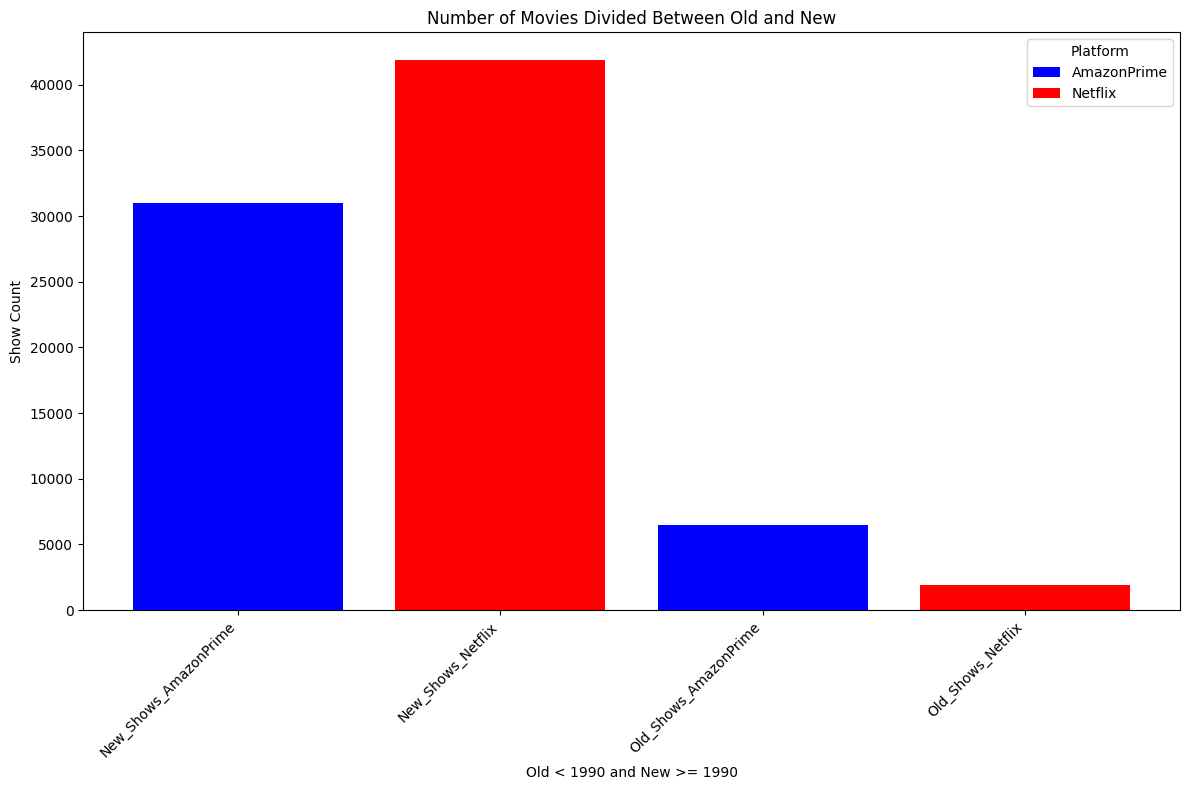

In [20]:
color_map = {
    'AmazonPrime': 'blue',
    'Netflix': 'red',
}

fig, ax = plt.subplots(figsize=(12, 8))

for (movie_era, platform), group in df.groupby(['Movie_Era', 'Platform']):
    color = color_map.get(platform, 'gray') 
    ax.bar(group['Movie_Era'] + '_' + group['Platform'], group['ShowCount'], label=platform, color=color)

# Beautify the x-labels
plt.xticks(rotation=45, ha="right")

ax.set_xlabel('Old < 1990 and New >= 1990')
ax.set_ylabel('Show Count')
ax.set_title('Number of Movies Divided Between Old and New')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[platform], label=platform) for platform in platforms]
ax.legend(handles=legend_elements, title='Platform')

plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()

In [48]:
query_avarage = """
SELECT 
    s.Release_Year as Release_Year,
    AVG(cast_count) as Average_Casting_Per_Show
FROM 
    Shows s
JOIN (
    SELECT
        fs.ID_Show,
        COUNT(DISTINCT c.ID) as cast_count 
    FROM 
        Full_Show fs
    JOIN 
        Casting c ON c.ID = fs.ID_Cast
	WHERE
		fs.ID_Type = '1'
    GROUP BY 
        fs.ID_Show
) as Show_Cast ON s.ID = Show_Cast.ID_Show
GROUP BY 
    Release_Year
ORDER BY 
    Release_Year;
"""

In [49]:
df_average = pd.read_sql_query(query_avarage, engine)

overall_average = df_average['Average_Casting_Per_Show'].mean()


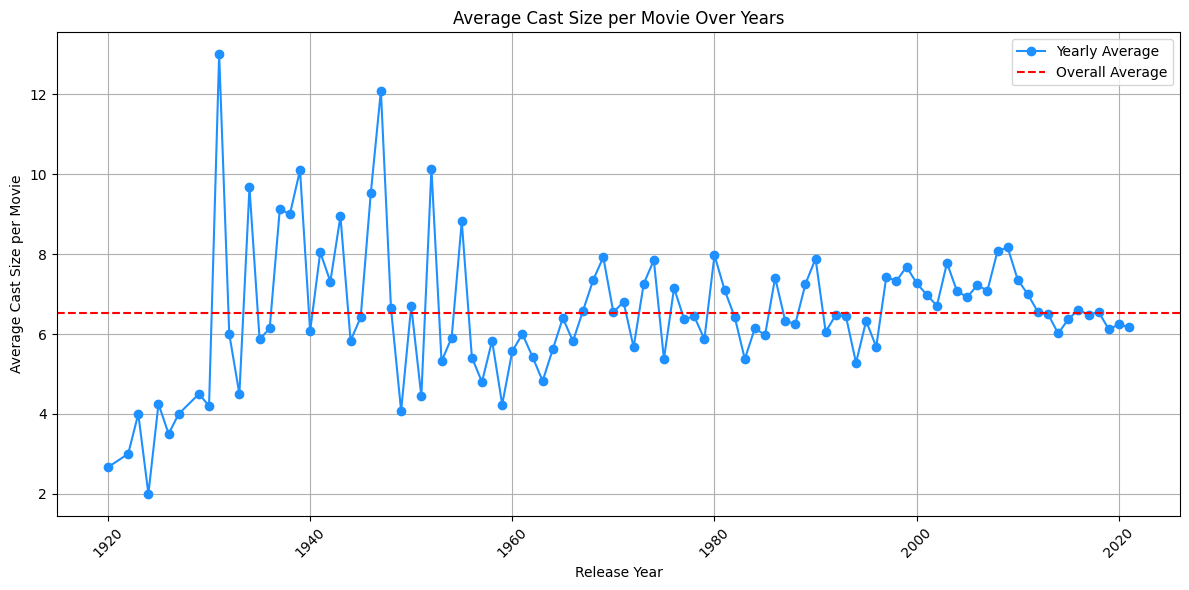

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(df_average['Release_Year'], df_average['Average_Casting_Per_Show'], marker='o', linestyle='-', color='dodgerblue', label='Yearly Average')
plt.axhline(y=overall_average, color='red', linestyle='--', label='Overall Average')

plt.xlabel('Release Year')
plt.ylabel('Average Cast Size per Movie')
plt.title('Average Cast Size per Movie Over Years')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [51]:
query_duration = """
SELECT a.Release_Year, ROUND(AVG(a.Duration), 0) as Average_Duration
FROM Shows a, Full_Show b
WHERE a.ID = b.ID_Show
AND b.ID_Type = '1'
GROUP BY a.Release_Year
ORDER BY a.Release_Year;
"""

In [52]:
df_duration = pd.read_sql_query(query_duration, engine)

overall_average_duration = df_duration['Average_Duration'].mean()

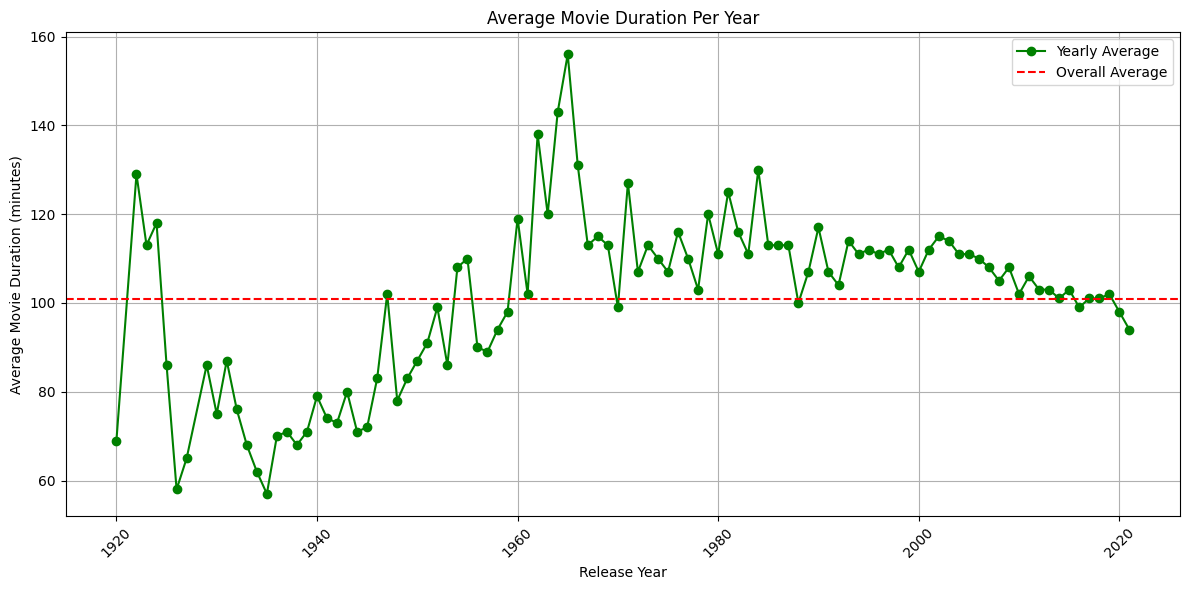

In [53]:
plt.figure(figsize=(12, 6))

plt.plot(df_duration['Release_Year'], df_duration['Average_Duration'], marker='o', linestyle='-', color='green', label='Yearly Average')

plt.axhline(y=overall_average_duration, color='red', linestyle='--', label='Overall Average')

plt.xlabel('Release Year')
plt.ylabel('Average Movie Duration (minutes)')
plt.title('Average Movie Duration Per Year')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()